In [27]:
import pandas as pd
import numpy as np
import pymc as pm
import seaborn as sns
import time
import itertools
import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hyperopt import fmin, tpe, hp, Trials
from mango import scheduler, Tuner

In [29]:
ds = pd.read_excel(r'RETAIL.xlsx', decimal=',')

df = pd.DataFrame(ds, columns=['date', 'sales'])

month_dict = {'Янв': 1, 'Фев': 2, 'Мар': 3, 'Апр': 4, 'Май': 5, 'Июн': 6, 'Июл': 7, 'Авг': 8, 'Сен': 9, 'Окт': 10, 'Ноя': 11, 'Дек': 12}
df['date'] = df['date'].apply(lambda x: pd.to_datetime(f"{month_dict[x.split('-')[0]]}-{x.split('-')[1]}"))

df.to_excel('data.xlsx')

df

,date,sales
0,1967-01-01,1697
1,1967-02-01,1599
2,1967-03-01,1765
3,1967-04-01,1803
4,1967-05-01,1891
...,...,...
404,2000-09-01,18901
405,2000-10-01,18856
406,2000-11-01,17856
407,2000-12-01,17647


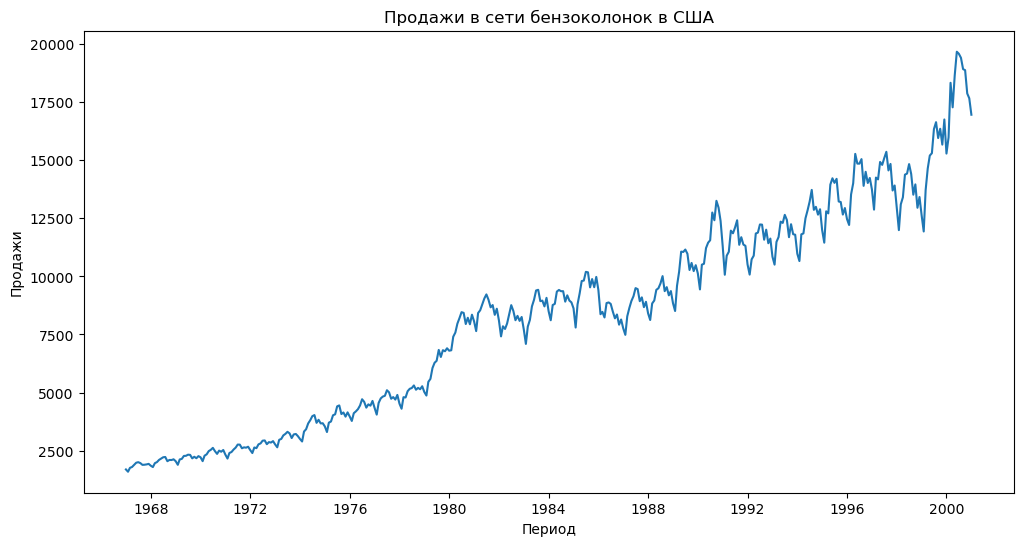

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'],df['sales'])
plt.title('Продажи в сети бензоколонок в США')
plt.xlabel('Период')
plt.ylabel('Продажи')
plt.show()

In [33]:
result = adfuller(df['sales'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: 0.7153238269202774
p-значение: 0.9901387734678273
Критические значения:
  1%: -3.4472291365835566
  5%: -2.8689795375849223
  10%: -2.5707330834976987


In [35]:
df['log_sales'] = np.log(df['sales'])

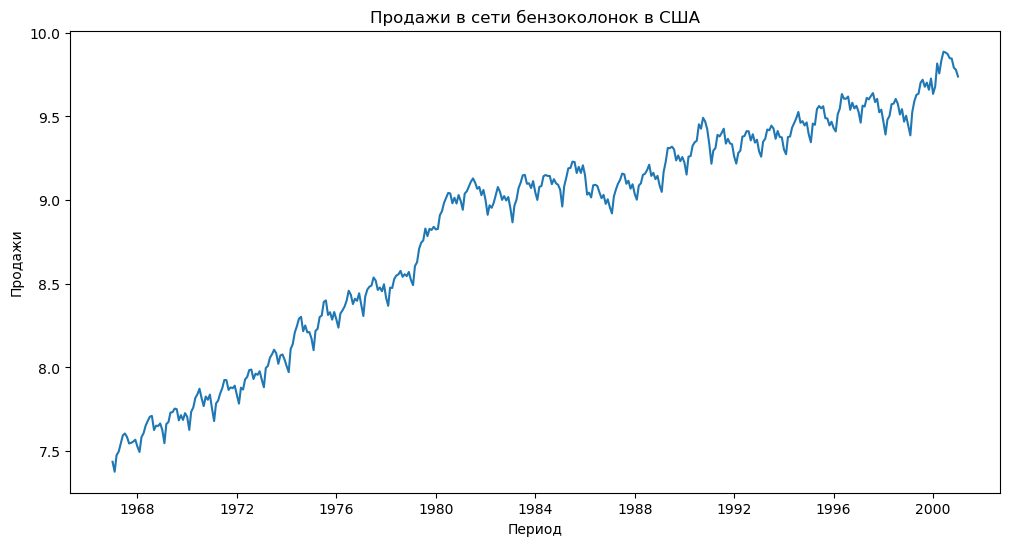

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['log_sales'])
plt.title('Продажи в сети бензоколонок в США')
plt.xlabel('Период')
plt.ylabel('Продажи')
plt.show()

In [39]:
result = adfuller(df['log_sales'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -1.3063440831044626
p-значение: 0.6262649129232984
Критические значения:
  1%: -3.447014064067954
  5%: -2.8688850015516016
  10%: -2.5706826870693797


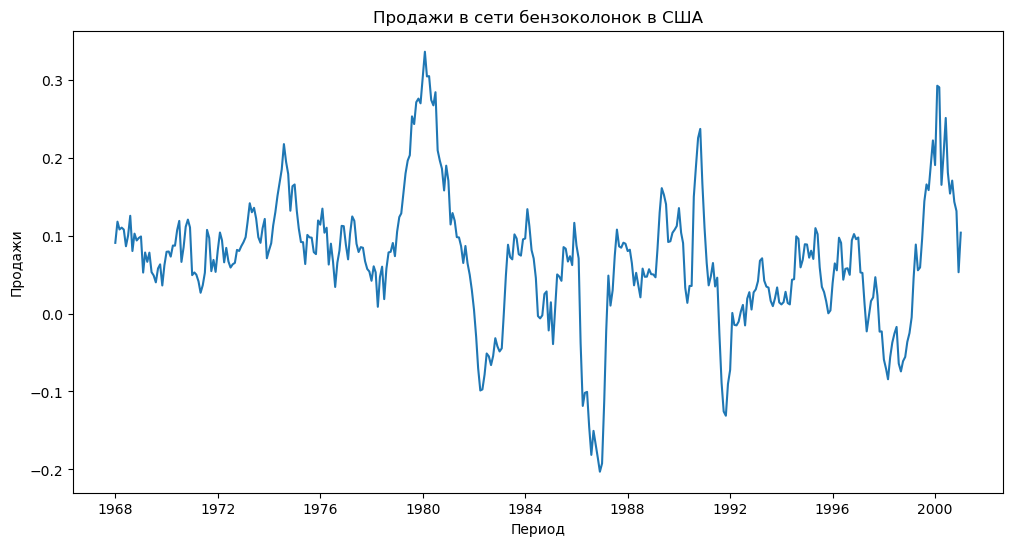

In [41]:
df['time_series_diff_1'] = df['log_sales'] - df['log_sales'].shift(12)

df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['time_series_diff_1'])
plt.title('Продажи в сети бензоколонок в США')
plt.xlabel('Период')
plt.ylabel('Продажи')
plt.show()

In [43]:
result = adfuller(df['time_series_diff_1'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -3.1065344992401522
p-значение: 0.026073370504808745
Критические значения:
  1%: -3.4474946672686824
  5%: -2.8690962436986855
  10%: -2.570795299750434


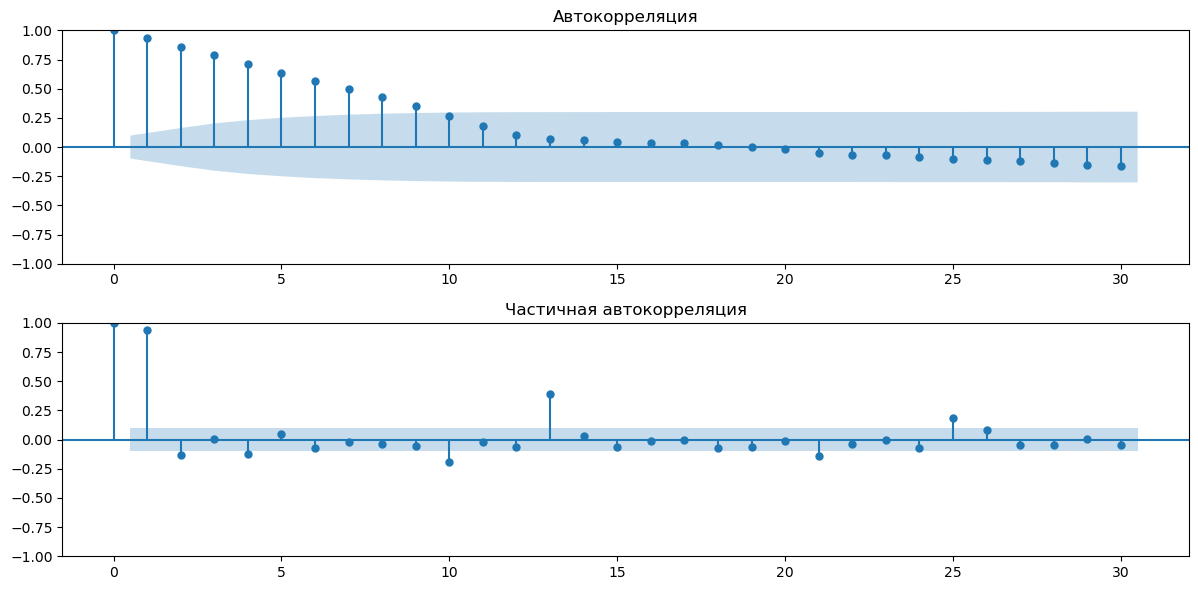

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['time_series_diff_1'], lags=30, ax=plt.gca())
plt.title('Автокорреляция')

plt.subplot(212)
plot_pacf(df['time_series_diff_1'], lags=30, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

In [59]:
%%time
p = range(0,30)
d = range(0,30)
q = range(0,30)

pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_bic = np.inf

for params in pdq:
    model_test = ARIMA(df['sales'], order = params)
    result_test = model_test.fit()
    
    if result_test.bic < best_bic:
        best_pdq = params
        best_bic = result_test.bic
    
print(f'Порядок авторегресии: {best_pdq[0]}\nПорядок дифференцирования: {best_pdq[1]}\nПорядок скользящего среднего: {best_pdq[2]}')
print(f'Наилучшее значение BIC: {best_bic}')


KeyboardInterrupt



In [49]:
p, d, q = best_pdq

model = ARIMA(df['sales'], order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  397
Model:                 ARIMA(8, 1, 2)   Log Likelihood               -2864.851
Date:                Mon, 13 May 2024   AIC                           5751.701
Time:                        20:51:40   BIC                           5795.497
Sample:                             0   HQIC                          5769.052
                                - 397                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1364      0.060    -19.000      0.000      -1.254      -1.019
ar.L2         -0.6329      0.077     -8.238      0.000      -0.783      -0.482
ar.L3          0.0773      0.075      1.035      0.3

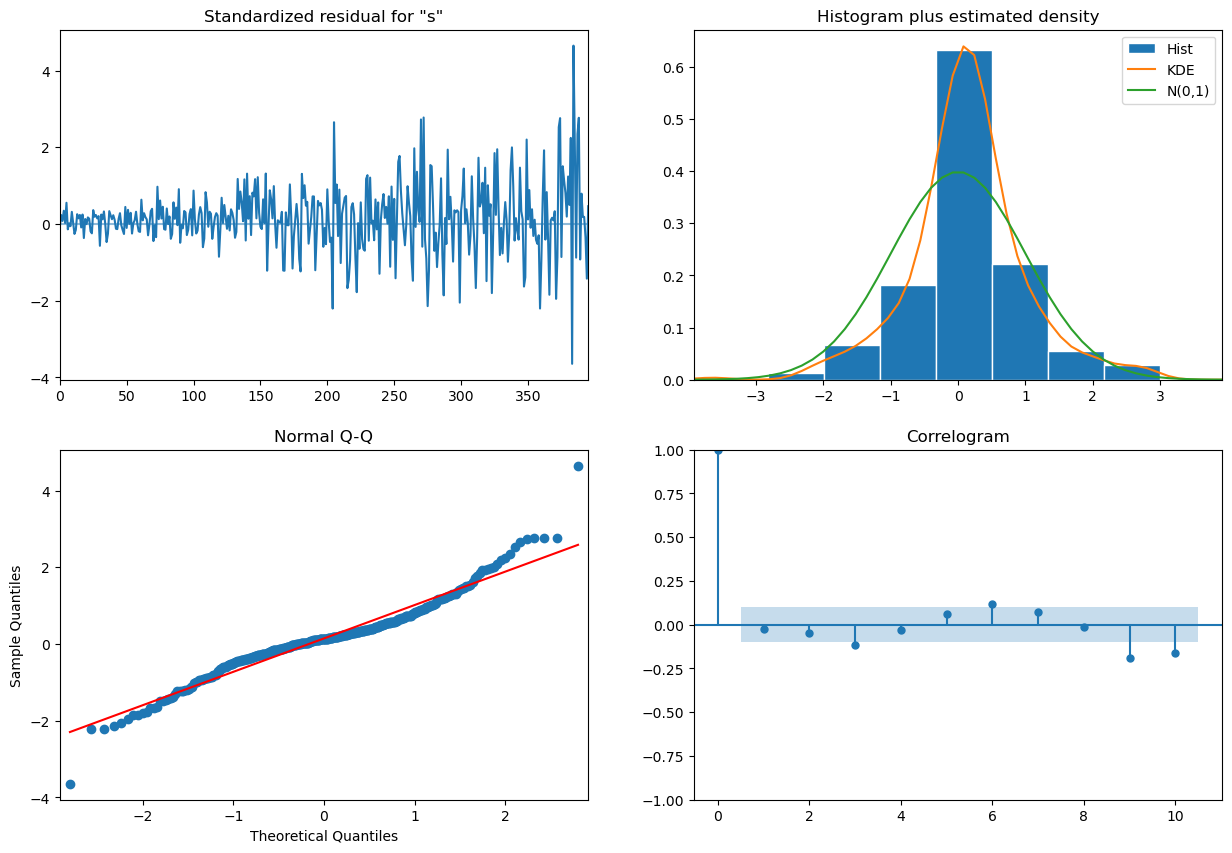

In [51]:
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

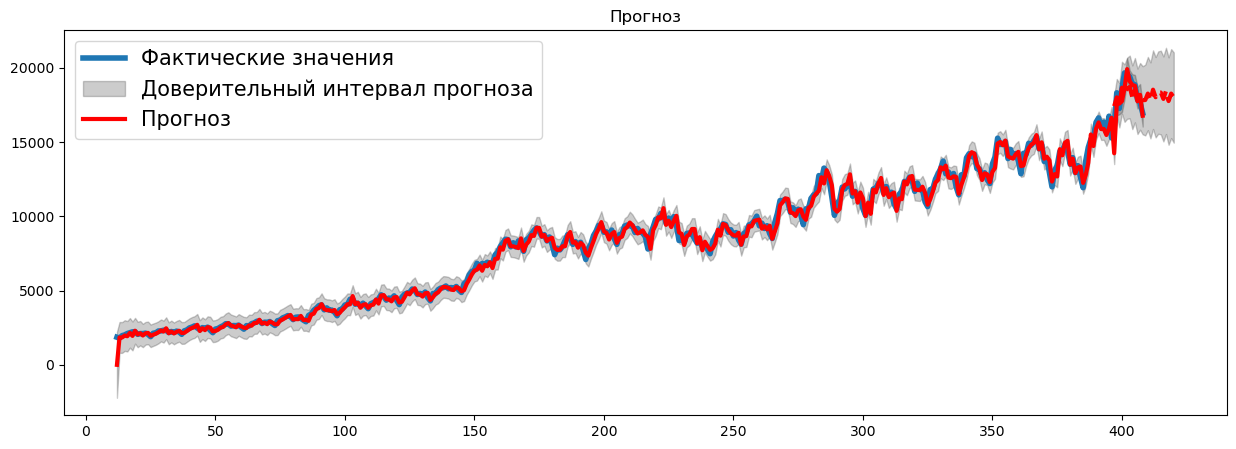

In [57]:
forecast = model_fit.get_prediction()
forecast_ci = forecast.conf_int()

plt.figure(figsize=(15,5))

plt.plot(df['sales'], label="Фактические значения", linewidth=4)
plt.fill_between(forecast_ci.index,
forecast_ci.iloc[:, 0],
forecast_ci.iloc[:, 1], color='k', alpha=.2, label='Доверительный интервал прогноза')
plt.plot(forecast.predicted_mean, color='red', label="Прогноз", linewidth=3)

forecast = model_fit.get_forecast(steps=24)
plt.plot(forecast.predicted_mean, color='red', linestyle='dashed', linewidth=3)
forecast_ci = forecast.conf_int()
plt.fill_between(forecast_ci.index,
forecast_ci.iloc[:, 0],
forecast_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend(fontsize=15)

plt.title('Прогноз')

plt.show()

In [55]:
forecast = model_fit.predict()

mse = mean_squared_error(df['sales'], forecast)

print(f'MSE: {mse}')

MSE: 116377.66874069531


In [61]:
%%time
def arima_objective_function(params):
    global data_values
    
    p, d, q = params
    
    try:
        model = ARIMA(data_values, order=(p, d, q))
        predictions = model.fit()
        y_pred = predictions.predict()
        mse = mean_squared_error(data_values, y_pred)
    except:
        mse = float('inf')
    
    return mse

param_space = [hp.choice('p', range(0, 30)), hp.choice('d', range(0, 30)), hp.choice('q', range(0, 30))]

data_values = df['sales']

trials = Trials()
best = fmin(fn=arima_objective_function, space=param_space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [06:52<00:00,  4.13s/trial, best loss: 80547.60241244106]    
CPU times: total: 17min 46s
Wall time: 6min 52s


In [19]:
print(best)
best_loss = trials.best_trial['result']['loss']
print('best loss:', best_loss)

{'d': 1, 'p': 18, 'q': 15}
best loss: 65275.271389437075


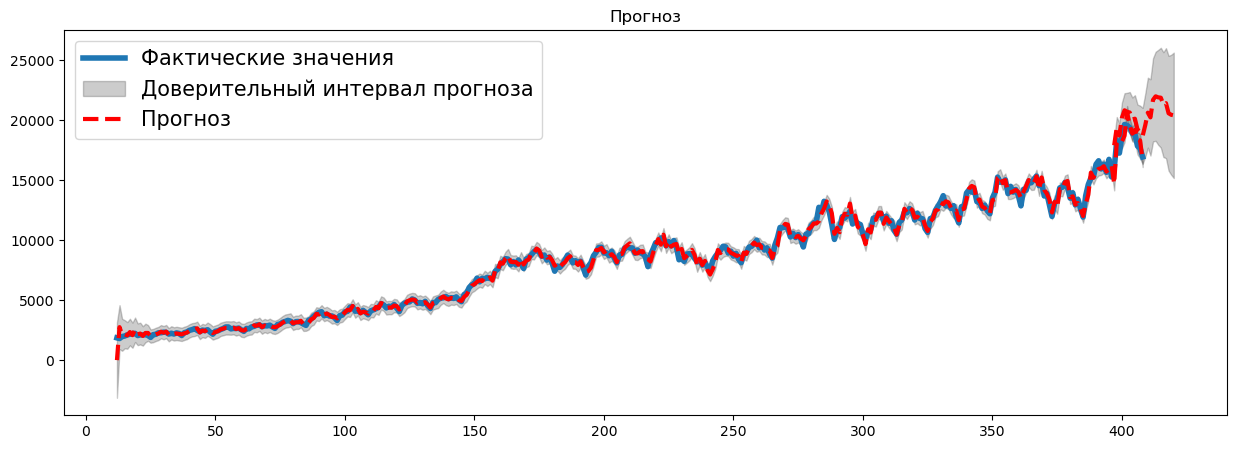

In [21]:
p, d, q = best['p'], best['d'], best['q']

model = ARIMA(data_values, order=(p, d, q))

forecast = model_fit.get_prediction()
forecast_ci = forecast.conf_int()

plt.figure(figsize=(15,5))

plt.plot(df['sales'], label="Фактические значения", linewidth=4)
plt.fill_between(forecast_ci.index,
forecast_ci.iloc[:, 0],
forecast_ci.iloc[:, 1], color='k', alpha=.2, label='Доверительный интервал прогноза')
plt.plot(forecast.predicted_mean, color='red', label="Прогноз", linestyle='dashed', linewidth=3)

forecast = model_fit.get_forecast(steps=24)
plt.plot(forecast.predicted_mean, color='red', linestyle='dashed', linewidth=3)
forecast_ci = forecast.conf_int()
plt.fill_between(forecast_ci.index,
forecast_ci.iloc[:, 0],
forecast_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend(fontsize=15)

plt.title('Прогноз')

plt.show()

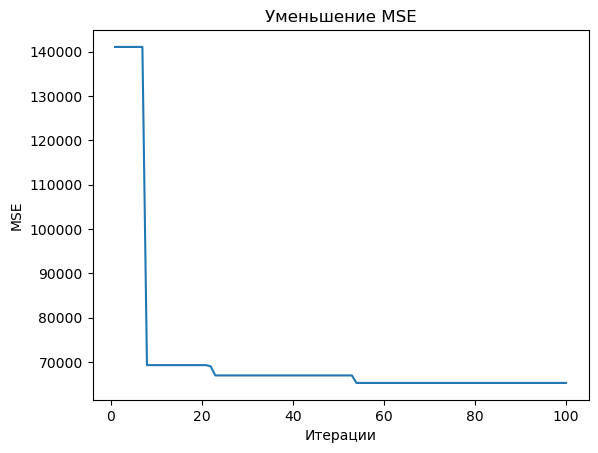

In [23]:
losses = [trial['result']['loss'] for trial in trials.trials]
best_losses = [min(losses[:i+1]) for i in range(len(losses))]

plt.plot(range(1, len(losses)+1), best_losses)
plt.xlabel('Итерации')
plt.ylabel('MSE')
plt.title('Уменьшение MSE')
plt.show()